In [0]:
pip install investpy

# Import Packages

In [4]:
import numpy as np
import pandas as pd
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
# from keras.models import load_model
# from keras import backend as K
import warnings

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
fig = (12,6)

Using TensorFlow backend.


In [5]:
import investpy
df  = investpy.get_stock_historical_data('ECO',country='colombia',
                                   from_date='01/01/2014', 
                                   to_date = '01/02/2020',
                                   interval='Daily')
df.tail()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-01-27,3285.0,3285.0,3195.0,3205.0,17911844,COP
2020-01-28,3210.0,3220.0,3190.0,3190.0,9741845,COP
2020-01-29,3200.0,3215.0,3185.0,3195.0,6951412,COP
2020-01-30,3180.0,3200.0,3145.0,3200.0,9469906,COP
2020-01-31,3210.0,3210.0,3140.0,3180.0,19502920,COP


In [6]:
len(df)

1482

# Historical Stock Price

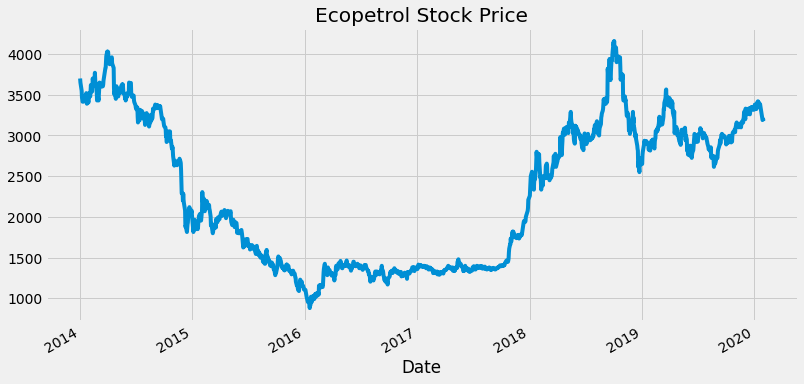

In [7]:
# Historical Price
df['Close'].plot(figsize=fig)
plt.title('Ecopetrol Stock Price');

# Log Return, Cumulative Return and Drawdown

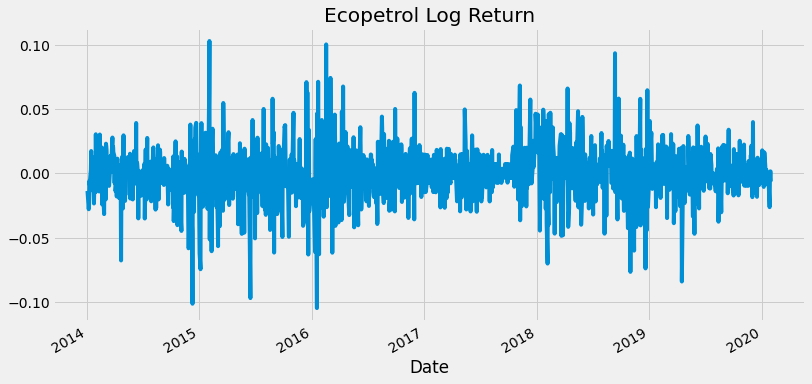

In [0]:
# Log Return
np.log(df.Close/df.Close.shift(1)).plot(figsize=fig)
plt.title('Ecopetrol Log Return');

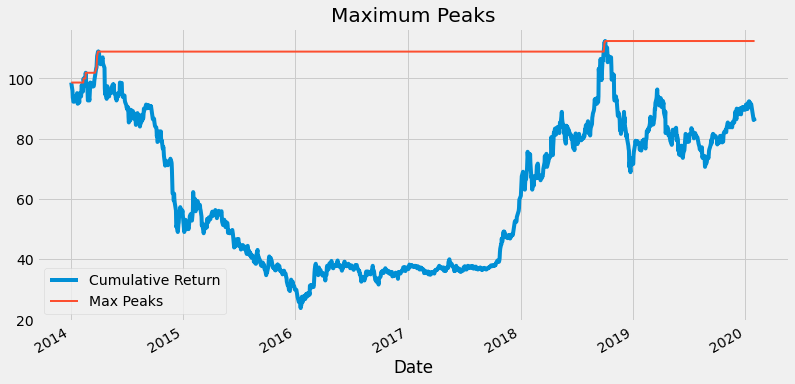

In [0]:
# Max Peaks
rets = df.Close.pct_change()
cum_ret =  100*(1 + rets).cumprod()
cum_ret.plot(label='Cumulative Return',figsize=fig,legend=True)
previous_peaks = cum_ret.cummax()
previous_peaks.plot(label='Max Peaks', lw=2,legend=True)
plt.title('Maximum Peaks');

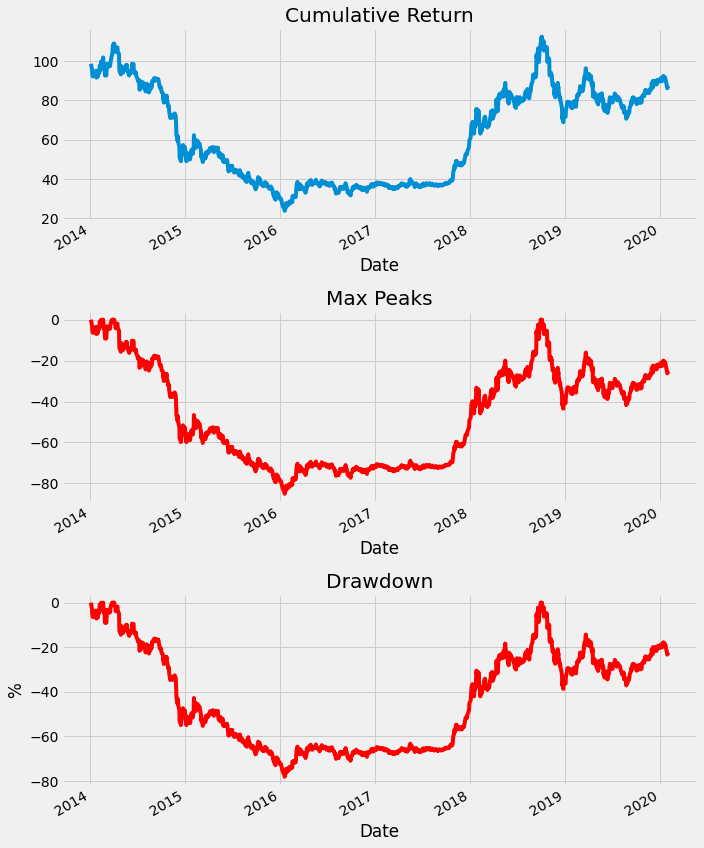

In [0]:
# Drawdown
f, ax = plt.subplots(3,figsize=(10,12))
cum_ret.plot(ax=ax[0],title='Cumulative Return')
(cum_ret-previous_peaks).plot(ax=ax[1], c='r',title='Max Peaks')
drawdown = (cum_ret - previous_peaks) / previous_peaks
(drawdown*100).plot(ax=ax[2],c='r',title='Drawdown')
ax[2].set_ylabel("%")
f.tight_layout();

In [0]:
# Max Drawdown
print('Max drawdown: {}%' .format(round(drawdown.min(),2)*100))
print('Date max drawdown: {}'.format(drawdown.idxmin()))

Max drawdown: -78.0%
Date max drawdown: 2016-01-18 00:00:00


In [0]:
# Max Drawdown by Date
print('Max drawdown: {}%' .format(round(drawdown['2018':'2019'].min(),2)*100))
print('Date max drawdown: {}'.format(drawdown['2018':'2019'].idxmin()))

Max drawdown: -44.0%
Date max drawdown: 2018-01-02 00:00:00


# LTSM

In [8]:
# Normalize Data
data = df.filter(['Close']).copy()
min_max_scaler = preprocessing.MinMaxScaler()
data['Close'] = min_max_scaler.fit_transform(data['Close'].values.reshape(-1,1))

data.tail(3)

,Close
Date,
2020-01-29,0.705703
2020-01-30,0.707228
2020-01-31,0.701128


In [0]:
# Convert to Array with 3 Dimensions
data = data.values
period = 91

scale_df = []
for i in range(len(data) - period):
    scale_df.append(data[i: i + period])
scale_df = np.array(scale_df)

In [10]:
scale_df.shape

(1391, 91, 1)

In [11]:
# Split Data
split_data = round(0.8 * scale_df.shape[0])

## Training (80%)
train = scale_df[:split_data,]
X_train = train[:, :-1] # all data until day 30
y_train = train[:, -1][:,-1] # day 31 close price
print('Training set:', train.shape[0], 'obs')

## Test (20%)
test = scale_df[split_data:, :]
X_test = test[:, :-1] # all data until day 30
y_test = test[:, -1][:,-1] # day 31 close price
print('Test set:', test.shape[0], 'obs')

Training set: 1113 obs
Test set: 278 obs


In [12]:
X_test.shape

(278, 90, 1)

In [13]:
X_train.shape

(1113, 90, 1)

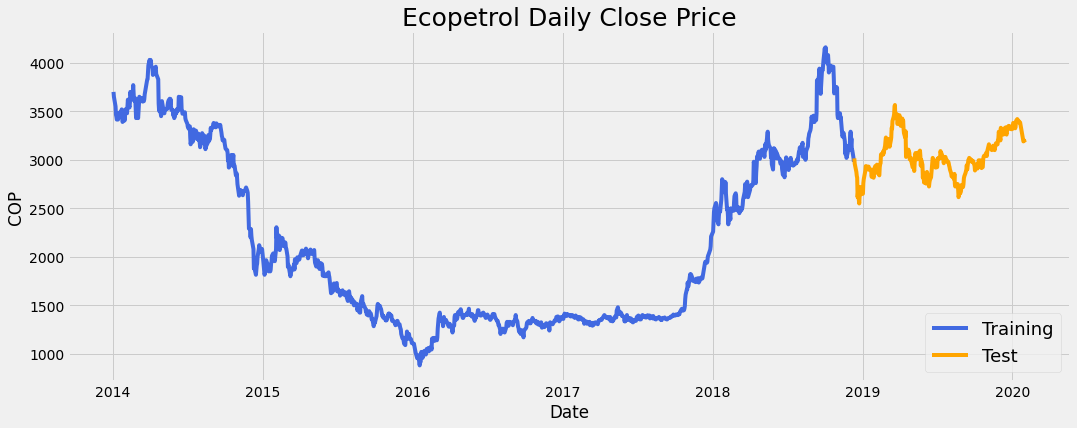

In [14]:
# Plot Train and Test Data
plt.figure(figsize=(16,6))
d_train = df.iloc[:(X_train.shape[0]+period)]
d_test = df.iloc[(X_train.shape[0]+period):len(df)]
plt.plot(d_train.index, d_train['Close'], color='royalblue', label='Training', linewidth = 4)
plt.plot(d_test.index, d_test['Close'], color='orange', label='Test', linewidth = 4)
plt.legend(loc='lower right', fontsize=18)
plt.title('Ecopetrol Daily Close Price', fontsize=25)
plt.ylabel('COP')
plt.xlabel('Date');

## Model 1

In [0]:
neurons = [256, 256, 32, 1]
shape = [90, 1, 1] 
dropout = 0.2 
decay = 0.5
epochs = 100

In [0]:
model = Sequential()

model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
model.add(Dropout(dropout))

model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 90, 256)           264192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 90, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 797,761
Trainable params: 797,761
Non-trainable params: 0
________________________________________________

In [0]:
adam = keras.optimizers.Adam(decay=decay)
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

In [0]:
history = model.fit(X_train, y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.2,
    verbose=1)

Train on 890 samples, validate on 223 samples
Epoch 1/100
890/890 [==============================] - 11s 13ms/step - loss: 0.1106 - accuracy: 0.0011 - val_loss: 0.4233 - val_accuracy: 0.0000e+00
Epoch 2/100
890/890 [==============================] - 10s 11ms/step - loss: 0.0934 - accuracy: 0.0011 - val_loss: 0.2303 - val_accuracy: 0.0000e+00
Epoch 3/100
890/890 [==============================] - 9s 11ms/step - loss: 0.0411 - accuracy: 0.0011 - val_loss: 0.0567 - val_accuracy: 0.0000e+00
Epoch 4/100
890/890 [==============================] - 9s 11ms/step - loss: 0.0280 - accuracy: 0.0011 - val_loss: 0.1276 - val_accuracy: 0.0000e+00
Epoch 5/100
890/890 [==============================] - 10s 11ms/step - loss: 0.0221 - accuracy: 0.0011 - val_loss: 0.0884 - val_accuracy: 0.0000e+00
Epoch 6/100
890/890 [==============================] - 9s 11ms/step - loss: 0.0112 - accuracy: 0.0011 - val_loss: 0.0084 - val_accuracy: 0.0045
Epoch 7/100
890/890 [==============================] - 9s 11ms/step

In [0]:
mse, acc = model.evaluate(X_test, y_test)
print("mean square error = ", mse)

278/278 [==============================] - 2s 6ms/step
mean square error =  0.002104828141298038


In [0]:
# Predictions
pred = model.predict(X_test)
pred = min_max_scaler.inverse_transform(pred)

y_test = y_test.reshape(-1, 1)
y_test = min_max_scaler.inverse_transform(y_test)

y_test = [i[0] for i in y_test]
pred = [i[0] for i in pred]

respred = d_test.copy()
respred['Close'] = pred

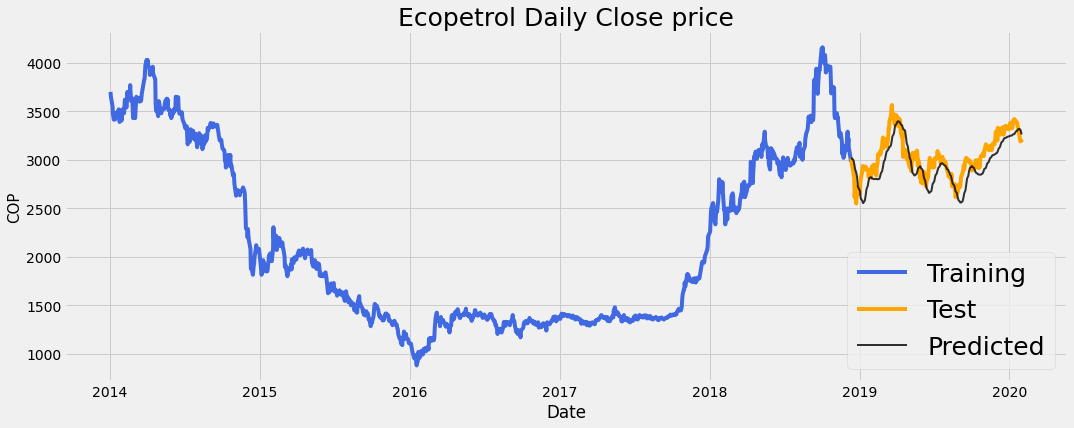

In [0]:
# Plot Predictions
plt.figure(figsize=(16,6))
plt.plot(d_train.index, d_train['Close'], color='royalblue', label='Training', linewidth = 4)
plt.plot(d_test.index, d_test['Close'], color='orange', label='Test', linewidth = 4)
plt.plot(d_test.index, respred['Close'], color='black', label='Predicted', linewidth = 2, alpha=0.8)
plt.legend(loc='lower right', fontsize=25)
plt.title('Ecopetrol Daily Close price', fontsize=25)
plt.xlabel('Date')
plt.ylabel('COP', fontsize=15);

### Next Day Prediction

In [0]:
# last 90 days
X_test = data[-90:]
# Reshape
X_test = np.reshape(X_test, (1, X_test.shape[0], 1))
X_test.shape

(1, 90, 1)

In [0]:
# Predict
predict_price = model.predict(X_test)
predict_price = min_max_scaler.inverse_transform(predict_price)

In [0]:
ecopetrol = investpy.get_stock_historical_data('ECO',country='colombia',
                                   from_date='31/01/2020',                          
                                   to_date = '03/02/2020',
                                   interval='Daily')
ecopetrol

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-01-31,3210.0,3210.0,3140.0,3180.0,19502920,COP
2020-02-03,3160.0,3160.0,3120.0,3140.0,7113412,COP


In [0]:
print('Real Close Price vs. Prediction:','\n')
print('Real: ', ecopetrol.Close.iloc[-1])
print('Prediction: {:.2f}'.format(float(predict_price)))
print('Difference: {:.2f}%'.format((float(predict_price)/ecopetrol.Close.iloc[-1] - 1)*100))

Real Close Price vs. Prediction: 

Real:  3140.0
Prediction: 3217.45
Difference: 2.47%


## Model 2

In [15]:
# LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 90, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [17]:
# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
1113/1113 [==============================] - 63s 56ms/step - loss: 0.0027 - accuracy: 0.0018
Epoch 2/30
1113/1113 [==============================] - 59s 53ms/step - loss: 0.0012 - accuracy: 0.0018
Epoch 3/30
1113/1113 [==============================] - 59s 53ms/step - loss: 8.4707e-04 - accuracy: 0.0018
Epoch 4/30
1113/1113 [==============================] - 59s 53ms/step - loss: 6.7692e-04 - accuracy: 0.0018
Epoch 5/30
1113/1113 [==============================] - 59s 53ms/step - loss: 5.1216e-04 - accuracy: 0.0018
Epoch 6/30
1113/1113 [==============================] - 59s 53ms/step - loss: 5.6739e-04 - accuracy: 0.0018
Epoch 7/30
1113/1113 [==============================] - 59s 53ms/step - loss: 4.9160e-04 - accuracy: 0.0018
Epoch 8/30
1113/1113 [==============================] - 58s 53ms/step - loss: 4.8969e-04 - accuracy: 0.0018
Epoch 9/30
1113/1113 [==============================] - 57s 51ms/step - loss: 4.1603e-04 - accuracy: 0.0018
Epoch 10/30
1113/1113 [=============

In [18]:
# Mean Square Error
mse = model.evaluate(X_test, y_test)
print("mean square error = ", mse)

278/278 [==============================] - 0s 836us/step
mean square error =  [0.00039147388373448, 0.0]


In [0]:
# Predictions
pred = model.predict(X_test)
pred = min_max_scaler.inverse_transform(pred)

y_test = y_test.reshape(-1, 1)
y_test = min_max_scaler.inverse_transform(y_test)

y_test = [i[0] for i in y_test]
pred = [i[0] for i in pred]

respred = d_test.copy()
respred['Close'] = pred

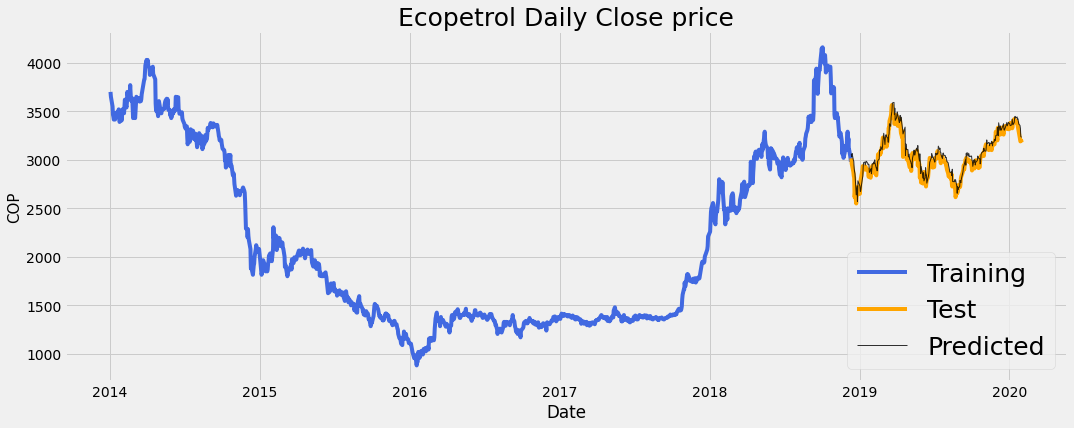

In [20]:
# Plot Predictions
plt.figure(figsize=(16,6))
plt.plot(d_train.index, d_train['Close'], color='royalblue', label='Training', linewidth = 4)
plt.plot(d_test.index, d_test['Close'], color='orange', label='Test', linewidth = 4)
plt.plot(d_test.index, respred['Close'], color='black', label='Predicted', linewidth = 1, alpha=0.8)
plt.legend(loc='lower right', fontsize=25)
plt.title('Ecopetrol Daily Close price', fontsize=25)
plt.xlabel('Date')
plt.ylabel('COP', fontsize=15);

### Next Day Prediction

In [21]:
# last 90 days
X_test = data[-90:]
# Reshape
X_test = np.reshape(X_test, (1, X_test.shape[0], 1))
X_test.shape

(1, 90, 1)

In [0]:
# Predict
predict_price = model.predict(X_test)
predict_price = min_max_scaler.inverse_transform(predict_price)

In [23]:
ecopetrol = investpy.get_stock_historical_data('ECO',country='colombia',
                                   from_date='31/01/2020',                          
                                   to_date = '03/02/2020',
                                   interval='Daily')
ecopetrol

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-01-31,3210.0,3210.0,3140.0,3180.0,19502920,COP
2020-02-03,3160.0,3160.0,3120.0,3140.0,7113412,COP


In [0]:
print('Real Close Price vs. Prediction:','\n')
print('Real: ', ecopetrol.Close.iloc[-1])
print('Prediction: {:.2f}'.format(float(predict_price)))
print('Difference: {:.2f}%'.format((float(predict_price)/ecopetrol.Close.iloc[-1] - 1)*100))

Real Close Price vs. Prediction: 

Real:  3140.0
Prediction: 3159.95
Difference: 0.64%
